<a href="https://colab.research.google.com/github/Nutsudapenpong/AIprototype2022/blob/main/Densenet_parasite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/New_yolo/Densenet

/content/drive/MyDrive/New_yolo/Densenet


In [3]:
#!wget http://www.vision.caltech.edu/Image_Datasets/Caltech256/256_ObjectCategories.tar

In [4]:
#a library to simplify training
!pip install pytorch-ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
#for unzipping tar files
#!tar -xf 256_ObjectCategories.tar

In [6]:
import torch
import torchvision
from torchvision import datasets, transforms #For loading our dataset
from torch import nn, optim # NN module and optimizers
from torch.nn import functional as F # Certain function, like sigmoid and tanh
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models # This is where we get our model.

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#For retina displays only

In [8]:
import numpy as np

In [9]:
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix

In [10]:
#writing a helper function to load data in
def get_data_loaders(data_dir, batch_size):
  transform = transforms.Compose([transforms.Resize(255), 
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor()])
  #Changing the image so that we can use it in our model
  all_images = datasets.ImageFolder(data_dir, transform=transform)
  train_images_len = int(len(all_images) * 0.75) #75% of images will be trained
  valid_images_len = int((len(all_images) - train_images_len)*0.5)
  test_images_len = int((len(all_images) - train_images_len - valid_images_len))
  train_data, val_data, test_data = random_split(all_images, [train_images_len, valid_images_len, test_images_len])
  train_loader = DataLoader(train_data, batch_size=batch_size)
  test_loader = DataLoader(test_data, batch_size=batch_size)
  val_loader = DataLoader(val_data, batch_size=batch_size)
  return (train_loader, val_loader, test_loader), all_images.classes

In [11]:
(train_loader, val_loader, test_loader), classes = get_data_loaders("/content/drive/MyDrive/New_yolo/Densenet/Parasite_eggs", 64)

In [12]:
print(classes)

['Ascaris', 'Echinostoma', 'Hookworm', 'MIF', 'OV', 'Taenia', 'Trichuris']


In [13]:
#build a helper function to format the text
#Goal is to turn a string like 007.bat to bat
import re
def formatText(string):
  string = string[4:]
  return string.replace("_", " ")
print(formatText(classes[0]))

ris


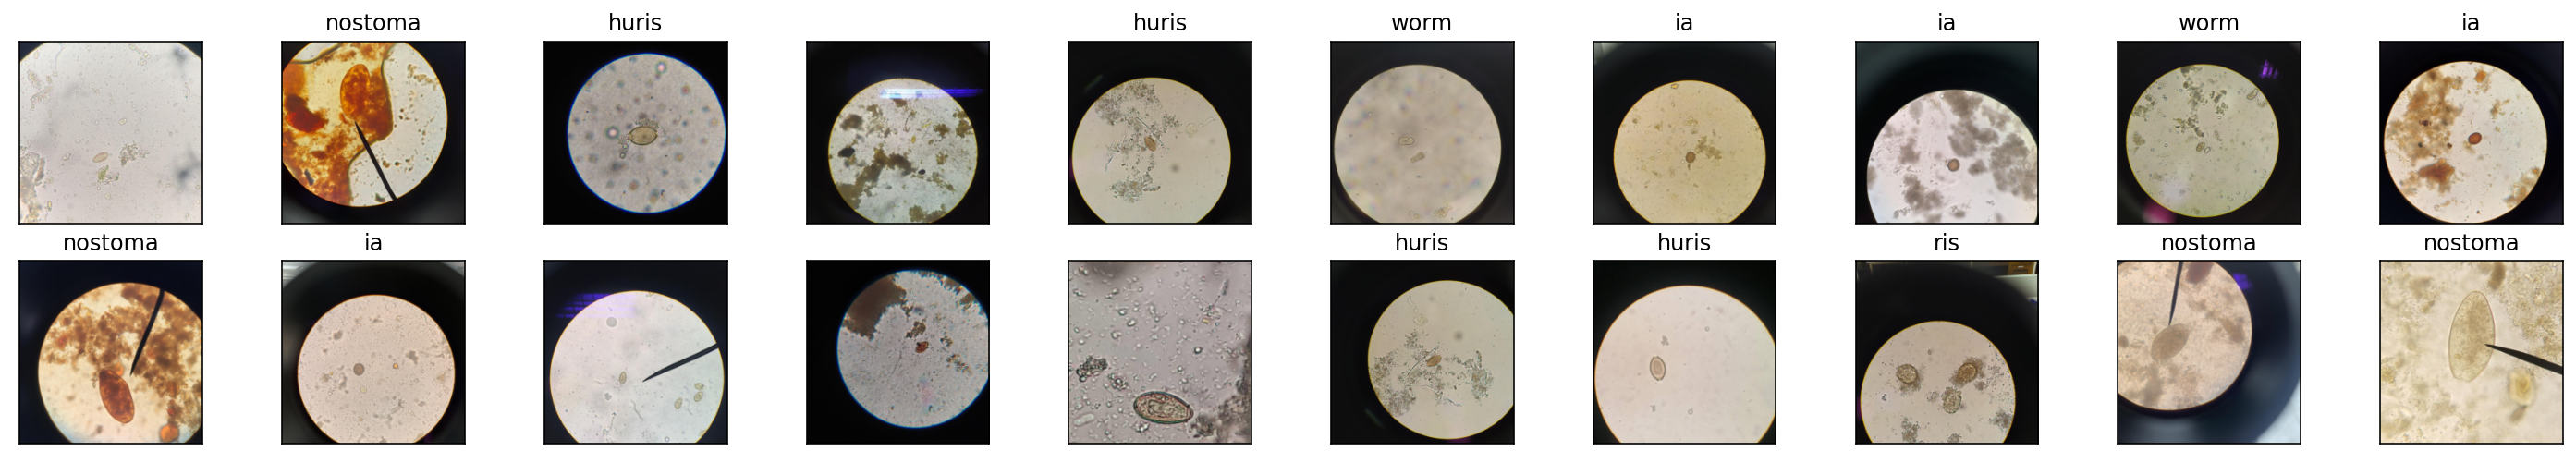

In [14]:
#Display training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

fig=plt.figure(figsize=(25,4))
for idx in np.arange(20): #only 20 images
  ax = fig.add_subplot(2, 20/2, idx + 1, xticks=[], yticks=[])
  #We don't need axes for the images
  plt.imshow(np.transpose(images[idx], (1, 2, 0)))
  ax.set_title(formatText(classes[labels[idx]]))

#training

In [15]:
#loading model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [16]:
model = models.densenet201(pretrained=True) #using densenet 201

In [17]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [18]:
#We need to change the last layer to have a output shape of 257
print(model.classifier.in_features)
print(model.classifier.out_features)

1920
1000


In [19]:
for param in model.parameters():
  param.requires_grad = False #We are freezing the model since it was trained on imageet and we do not need to train that part agian 

In [20]:
n_inputs = model.classifier.in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier = last_layer
print(model.classifier.out_features)

7


In [21]:
#Moving our model to GPU
model = model.to(device)

In [22]:
#Defining our optimizer and loss function
criterion = nn.CrossEntropyLoss() #This is our loss function
optimizer = optim.Adam(model.classifier.parameters()) #Feed parameters to the model

In [23]:
#Training model
training_history = {'accuracy':[], 'loss':[]}
validation_history = {'accuracy':[], 'loss':[]}

In [24]:
#Now we will use PyTorch Ignite's feaures
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(model,
                                       device=device,
                                       metrics={
                                           'accuracy':Accuracy(),
                                           'loss': Loss(criterion),
                                           'cm':ConfusionMatrix(len(classes))}
                                      )
#Creating even handlers to show our training progress
@trainer.on(Events.ITERATION_COMPLETED)
def log_a_dot(engine):
  print(".", end="")

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
  evaluator.run(train_loader)
  metrics = evaluator.state.metrics
  accuracy = metrics['accuracy']*100
  loss = metrics['loss']
  training_history['accuracy'].append(accuracy)
  training_history['loss'].append(loss)
  print()
  print(f"Training results - Epoch: {trainer.state.epoch} Avg accuracy: {accuracy} Loss: {loss}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
  evaluator.run(val_loader)
  metrics = evaluator.state.metrics
  accuracy = metrics['accuracy']*100
  loss = metrics['loss']
  validation_history['accuracy'].append(accuracy)
  validation_history['loss'].append(loss)
  print()
  print(f"Validation results - Epoch: {trainer.state.epoch} Avg accuracy: {accuracy} Loss: {loss}")

In [25]:
trainer.run(train_loader, max_epochs=10)

...........
Training results - Epoch: 1 Avg accuracy: 28.70514820592824 Loss: 1.636178860240347

Validation results - Epoch: 1 Avg accuracy: 19.626168224299064 Loss: 1.7917933954256717
...........
Training results - Epoch: 2 Avg accuracy: 50.390015600624025 Loss: 1.3944164163050896

Validation results - Epoch: 2 Avg accuracy: 42.99065420560748 Loss: 1.5130871924284464
...........
Training results - Epoch: 3 Avg accuracy: 57.56630265210608 Loss: 1.2442155620795143

Validation results - Epoch: 3 Avg accuracy: 53.271028037383175 Loss: 1.3811374557352512
...........
Training results - Epoch: 4 Avg accuracy: 65.21060842433697 Loss: 1.1009228210925313

Validation results - Epoch: 4 Avg accuracy: 58.87850467289719 Loss: 1.2497611357786944
...........
Training results - Epoch: 5 Avg accuracy: 71.29485179407176 Loss: 0.9839866031164685

Validation results - Epoch: 5 Avg accuracy: 60.747663551401864 Loss: 1.157590491749416
...........
Training results - Epoch: 6 Avg accuracy: 74.72698907956318 L

State:
	iteration: 110
	epoch: 10
	epoch_length: 11
	max_epochs: 10
	output: 0.9700933694839478
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

Testing

Text(0.5, 1.0, 'Validation loss')

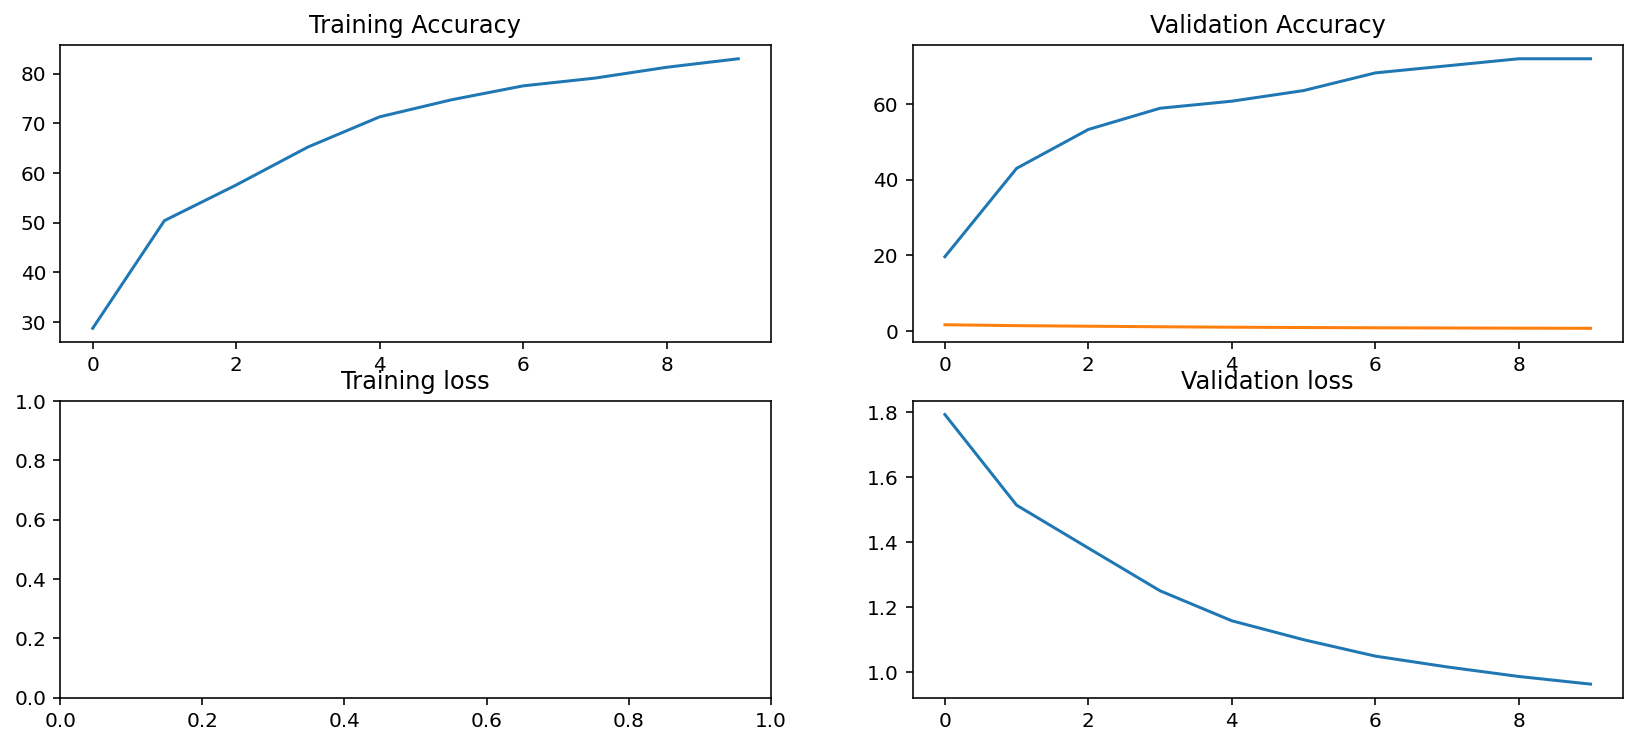

In [26]:
fig, axs = plt.subplots(2,2)
fig.set_figheight(6)
fig.set_figwidth(14)
axs[0, 0].plot(training_history["accuracy"])
axs[0, 0].set_title("Training Accuracy")
axs[0, 1].plot(validation_history["accuracy"])
axs[0, 1].set_title("Validation Accuracy")
axs[0, 1].plot(training_history["loss"])
axs[1, 0].set_title("Training loss")
axs[1, 1].plot(validation_history["loss"])
axs[1, 1].set_title("Validation loss")

In [27]:
test_loss = 0.0
class_correct = np.zeros((len(classes)))
class_total = np.zeros((len(classes)))
model.eval() #Setting model to evaluation mode

for data, target in test_loader:
  if torch.cuda.is_available():
    data, target = data.cuda(), target.cuda()
  output = model(data)
  loss = criterion(output, target)
  test_loss += loss.item() * data.size(0)
  _, pred = torch.max(output, 1)
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
  if len(target) == 64:
    for i in range(64):
      label = target.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1
test_loss /= len(test_loader.dataset)
print("Test Loss: {:.6f}\n".format(test_loss))

for i in range(len(classes)):
  if class_total[i] > 0:
    print("Test Accuracy of {}: {} ({}/{})".format(
        classes[i], 100*class_correct[i] / class_total[i],
        np.sum(class_correct[i]), np.sum(class_total[i])
    ))
  else:
    print("Test Accuracy of {}: N/A (since there are no examples)".format(classes[i]))
print("Test Accuracy Overall: {} ({}/{})".format(
        100*np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)
    ))

Test Loss: 0.902951

Test Accuracy of Ascaris: 71.42857142857143 (5.0/7.0)
Test Accuracy of Echinostoma: 66.66666666666667 (8.0/12.0)
Test Accuracy of Hookworm: 71.42857142857143 (5.0/7.0)
Test Accuracy of MIF: 100.0 (4.0/4.0)
Test Accuracy of OV: 57.142857142857146 (4.0/7.0)
Test Accuracy of Taenia: 83.33333333333333 (15.0/18.0)
Test Accuracy of Trichuris: 77.77777777777777 (7.0/9.0)
Test Accuracy Overall: 75.0 (48.0/64.0)


In [28]:
(train_loader2, val_loader2, test_loader2), classes2 = get_data_loaders("/content/drive/MyDrive/New_yolo/Densenet/Parasiteaddout", 64)

In [30]:
import csv

In [36]:
train_csv =  '/content/drive/MyDrive/New_yolo/Densenet/train.csv'

In [42]:
temper = 1000
test_loss = 0.0
class_correct = np.zeros((len(classes2)))
class_total = np.zeros((len(classes2)))
model.eval()
_list = []
for data, target in train_loader2:
  if torch.cuda.is_available():
    data, target = data.cuda(), target.cuda()
  output = model(data)

  ####################################
  outputs = output / temper
  nnOutputs = outputs.data.cpu()
  nnOutputs = nnOutputs.numpy()
                          
                  #nnOutputs = nnOutputs[0]

                  #print("nnOutputs2")
                  #print(nnOutputs)
                          
  nnOutputs = nnOutputs - np.max(nnOutputs)                
  nnOutputs = np.exp(nnOutputs)/np.sum(np.exp(nnOutputs))
  max_out1 = np.max(nnOutputs)
  print("________")
  print(output)
  print(max_out1)
  print(target)
  ################################
  
  for obj in range(len(output)):
    _imageRow = []
    img = output[obj]
    img = img.data.cpu()
    img = img.numpy()
    print("4468")
    print(img)
    #_imageRow.append(img['checksum'])
    _imageRow.append(img[0])
    _imageRow.append(img[1])
    _imageRow.append(img[2])
    _imageRow.append(img[3])
    _imageRow.append(img[4])
    _imageRow.append(img[5])
    _imageRow.append(img[6])
    
    img2 = target[obj]
    img2 = img2.data.cpu()
    img2 = img2.numpy()
    _imageRow.append(img2)
    
    _list.append(_imageRow)
  
  
  ################################################

  loss = criterion(output, target)
  test_loss += loss.item() * data.size(0)
  _, pred = torch.max(output, 1)
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
  if len(target) == 64:
    for i in range(64):
      label = target.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1
test_loss /= len(test_loader.dataset)
print("Test Loss: {:.6f}\n".format(test_loss))

for i in range(len(classes)):
  if class_total[i] > 0:
    print("Test Accuracy of {}: {} ({}/{})".format(
        classes[i], 100*class_correct[i] / class_total[i],
        np.sum(class_correct[i]), np.sum(class_total[i])
    ))
  else:
    print("Test Accuracy of {}: N/A (since there are no examples)".format(classes[i]))
print("Test Accuracy Overall: {} ({}/{})".format(
        100*np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)
    ))

with open(train_csv, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['pathname', 'shapeR', 'shapeC', 'bbminR', 'bbminC', 'bbmaxR', 'bbmaxC', 'category'])
    writer.writerows(_list)

________
tensor([[-1.1195e+00, -1.6300e+00, -3.0487e+00, -2.6928e+00, -2.2129e+00,
          1.1839e+00, -2.1672e+00],
        [-3.7080e-01,  7.7783e-02, -9.7700e-01, -1.8564e+00, -1.9367e+00,
          1.4705e-01, -1.0686e+00],
        [-1.0427e+00, -1.9536e+00, -2.5957e+00,  1.5450e+00,  8.5490e-01,
         -8.1027e-01, -1.2788e+00],
        [-2.0024e-01, -1.9067e+00, -1.2357e+00, -2.8164e+00, -1.3268e+00,
         -5.4127e-01,  9.3498e-01],
        [ 1.8484e-01, -5.7098e-01, -1.9709e+00, -1.6948e+00, -1.0206e+00,
         -3.1575e-01, -1.3562e+00],
        [ 2.6421e-01,  1.5293e+00, -2.0579e+00, -3.9808e+00, -3.5552e+00,
         -1.3311e-02, -1.1228e+00],
        [-5.7761e-01, -3.6410e-01, -1.5724e+00, -2.3367e+00, -8.0155e-01,
          8.0828e-01, -2.3629e+00],
        [-1.1706e+00, -1.3051e+00, -4.2637e+00,  3.8703e-01,  8.9344e-01,
         -5.1944e-01, -1.5357e+00],
        [-3.4441e-01,  1.0802e+00, -3.9449e+00, -3.5613e+00, -1.8797e+00,
         -1.5217e-01, -2.0452e+00],
 

In [43]:
val_csv =  '/content/drive/MyDrive/New_yolo/Densenet/val.csv'

In [44]:
temper = 1000
test_loss = 0.0
class_correct = np.zeros((len(classes2)))
class_total = np.zeros((len(classes2)))
model.eval()
_list = []
for data, target in val_loader2:
  if torch.cuda.is_available():
    data, target = data.cuda(), target.cuda()
  output = model(data)

  ####################################
  outputs = output / temper
  nnOutputs = outputs.data.cpu()
  nnOutputs = nnOutputs.numpy()
                          
                  #nnOutputs = nnOutputs[0]

                  #print("nnOutputs2")
                  #print(nnOutputs)
                          
  nnOutputs = nnOutputs - np.max(nnOutputs)                
  nnOutputs = np.exp(nnOutputs)/np.sum(np.exp(nnOutputs))
  max_out1 = np.max(nnOutputs)
  print("________")
  print(output)
  print(max_out1)
  print(target)

  ################################
  
  for obj in range(len(output)):
    _imageRow = []
    img = output[obj]
    img = img.data.cpu()
    img = img.numpy()
    print("4468")
    print(img)
    #_imageRow.append(img['checksum'])
    _imageRow.append(img[0])
    _imageRow.append(img[1])
    _imageRow.append(img[2])
    _imageRow.append(img[3])
    _imageRow.append(img[4])
    _imageRow.append(img[5])
    _imageRow.append(img[6])
    
    img2 = target[obj]
    img2 = img2.data.cpu()
    img2 = img2.numpy()
    _imageRow.append(img2)
    
    _list.append(_imageRow)
  
  
  ################################################


  loss = criterion(output, target)
  test_loss += loss.item() * data.size(0)
  _, pred = torch.max(output, 1)
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
  if len(target) == 64:
    for i in range(64):
      label = target.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1
test_loss /= len(test_loader.dataset)
print("Test Loss: {:.6f}\n".format(test_loss))

for i in range(len(classes)):
  if class_total[i] > 0:
    print("Test Accuracy of {}: {} ({}/{})".format(
        classes[i], 100*class_correct[i] / class_total[i],
        np.sum(class_correct[i]), np.sum(class_total[i])
    ))
  else:
    print("Test Accuracy of {}: N/A (since there are no examples)".format(classes[i]))
print("Test Accuracy Overall: {} ({}/{})".format(
        100*np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)
    ))

with open(val_csv, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['pathname', 'shapeR', 'shapeC', 'bbminR', 'bbminC', 'bbmaxR', 'bbmaxC', 'category'])
    writer.writerows(_list)

________
tensor([[-8.5304e-01, -4.6966e-01, -3.5230e+00, -2.3763e+00, -1.8522e+00,
          5.0783e-01, -1.3986e+00],
        [ 1.3757e-01, -2.4027e+00, -2.1924e+00, -1.2845e+00, -9.6207e-02,
         -7.5880e-01, -1.9058e+00],
        [-3.0542e-01, -2.1952e+00, -2.4430e+00, -8.1315e-01, -9.4635e-01,
         -5.6584e-01, -3.7190e-01],
        [-9.2588e-01,  2.9475e-01, -2.7846e+00, -3.7625e+00, -2.4757e+00,
          1.1422e+00, -2.4300e+00],
        [-5.5425e-01,  1.8123e-01, -1.3997e-02, -2.8786e+00, -1.6163e+00,
         -3.9824e-01, -9.4429e-01],
        [-1.5666e-01, -1.8090e+00, -4.7285e+00, -2.9032e+00, -5.3452e-01,
          1.0120e-01, -9.9255e-01],
        [ 5.5020e-01, -1.4063e+00, -2.0500e+00, -2.4058e+00, -2.9970e+00,
         -1.3787e-01, -7.1033e-01],
        [-2.5470e-01,  1.2897e+00, -3.2950e+00, -3.0308e+00, -1.1889e+00,
          5.4758e-01, -1.8917e+00],
        [ 9.6088e-01, -1.4784e+00, -2.7591e+00, -2.4702e+00, -1.7128e+00,
         -1.0434e+00, -3.6788e-01],
 

In [45]:
test_csv =  '/content/drive/MyDrive/New_yolo/Densenet/test.csv'

In [46]:
temper = 1000
test_loss = 0.0
class_correct = np.zeros((len(classes2)))
class_total = np.zeros((len(classes2)))
model.eval()
_list = []
for data, target in test_loader2:
  if torch.cuda.is_available():
    data, target = data.cuda(), target.cuda()
  output = model(data)

  ####################################
  outputs = output / temper
  nnOutputs = outputs.data.cpu()
  nnOutputs = nnOutputs.numpy()
                          
                  #nnOutputs = nnOutputs[0]

                  #print("nnOutputs2")
                  #print(nnOutputs)
                          
  nnOutputs = nnOutputs - np.max(nnOutputs)                
  nnOutputs = np.exp(nnOutputs)/np.sum(np.exp(nnOutputs))
  max_out1 = np.max(nnOutputs)
  print("________")
  print(output)
  print(max_out1)
  print(target)

  ################################
  
  for obj in range(len(output)):
    _imageRow = []
    img = output[obj]
    img = img.data.cpu()
    img = img.numpy()
    print("4468")
    print(img)
    #_imageRow.append(img['checksum'])
    _imageRow.append(img[0])
    _imageRow.append(img[1])
    _imageRow.append(img[2])
    _imageRow.append(img[3])
    _imageRow.append(img[4])
    _imageRow.append(img[5])
    _imageRow.append(img[6])
    
    img2 = target[obj]
    img2 = img2.data.cpu()
    img2 = img2.numpy()
    _imageRow.append(img2)
    
    _list.append(_imageRow)
  
  
  ################################################


  loss = criterion(output, target)
  test_loss += loss.item() * data.size(0)
  _, pred = torch.max(output, 1)
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
  if len(target) == 64:
    for i in range(64):
      label = target.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1
test_loss /= len(test_loader.dataset)
print("Test Loss: {:.6f}\n".format(test_loss))

for i in range(len(classes)):
  if class_total[i] > 0:
    print("Test Accuracy of {}: {} ({}/{})".format(
        classes[i], 100*class_correct[i] / class_total[i],
        np.sum(class_correct[i]), np.sum(class_total[i])
    ))
  else:
    print("Test Accuracy of {}: N/A (since there are no examples)".format(classes[i]))
print("Test Accuracy Overall: {} ({}/{})".format(
        100*np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)
    ))

with open(test_csv, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['pathname', 'shapeR', 'shapeC', 'bbminR', 'bbminC', 'bbmaxR', 'bbmaxC', 'category'])
    writer.writerows(_list)

________
tensor([[-0.4796, -1.6618, -2.5960, -1.1470, -0.0450, -0.2771, -2.4376],
        [ 0.1242, -1.0370, -2.9126, -0.3815, -1.3703, -0.3084, -0.7966],
        [ 0.2774, -3.0403, -3.5021, -2.3085, -0.4029, -0.1632, -2.1216],
        [ 0.4762, -0.5658, -4.4453, -2.8416, -0.1582, -0.2425, -1.6427],
        [-0.1733, -0.1297, -2.9387, -2.1868, -0.3675,  0.6302, -2.9927],
        [-0.1698, -0.1066,  0.1251, -3.0055, -2.6438, -0.3156, -1.7933],
        [ 0.0370, -2.3962, -0.9601, -1.1782,  0.3114, -0.6168, -1.4730],
        [-0.5442, -0.0967, -3.1246, -1.6697, -0.2174, -0.0873, -0.1804],
        [-0.9085,  0.2731,  0.0096, -1.1923, -1.0388, -1.1189, -1.3501],
        [-0.8480, -0.4392, -3.2363, -1.8572, -1.2767, -0.5077, -2.2091],
        [-0.8396,  0.1850, -4.0585, -2.6706, -1.6641,  0.4566, -2.3518],
        [-0.3718, -2.3362, -4.3304, -3.4743,  0.1034,  0.1273, -2.0341],
        [-0.5477, -1.6655, -3.7387, -0.5162, -0.6224, -0.2497, -1.9169],
        [ 0.0847, -1.3599, -1.2323, -1.868